$$
\begin{align}
 Y &= f(X_0, X_1) + \epsilon = X_0 + X_1^2 + \epsilon
\end{align}
$$



In [22]:
from dataclasses import dataclass
from typing import Any
from collections.abc import Callable
from __future__ import annotations  # 型ヒント用
import warnings

import numpy as np
import scipy as sp
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.extmath import cartesian
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # matplotlibの日本語表示対応

from mli import PartialDependence, Marginal, AccumulatedLocalEffects

In [24]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

In [2]:
def f(X: np.ndarray) -> np.ndarray:
    """真の関数形：f(X0, X1) = X0 + X1^2"""
    return X[:, 0] + X[:, 1] ** 2


def generate_simulation_data(
    N: int = 10000,
    rho: float = 0.99,
    sigma_e: float = 0.01,
    f: Callable[[np.ndarray], np.ndarray] = f,
) -> tuple[np.ndarray, np.ndarray]:
    """シミュレーションデータを生成する関数"""
    
    # 説明変数同士は相関している
    mu = np.array([0, 0])
    Sigma = np.array([[1, rho], [rho, 1]])
    X = np.random.multivariate_normal(mu, Sigma, N)
    for j in range(2):
        # こうすると一様分布に従うようになる
        X[:, j] = sp.stats.norm().cdf(X[:, j])
    
    # ノイズ
    e = np.random.normal(0, sigma_e, N)
    
    # 目的変数
    y = f(X) + e

    return X, y


X, y = generate_simulation_data()

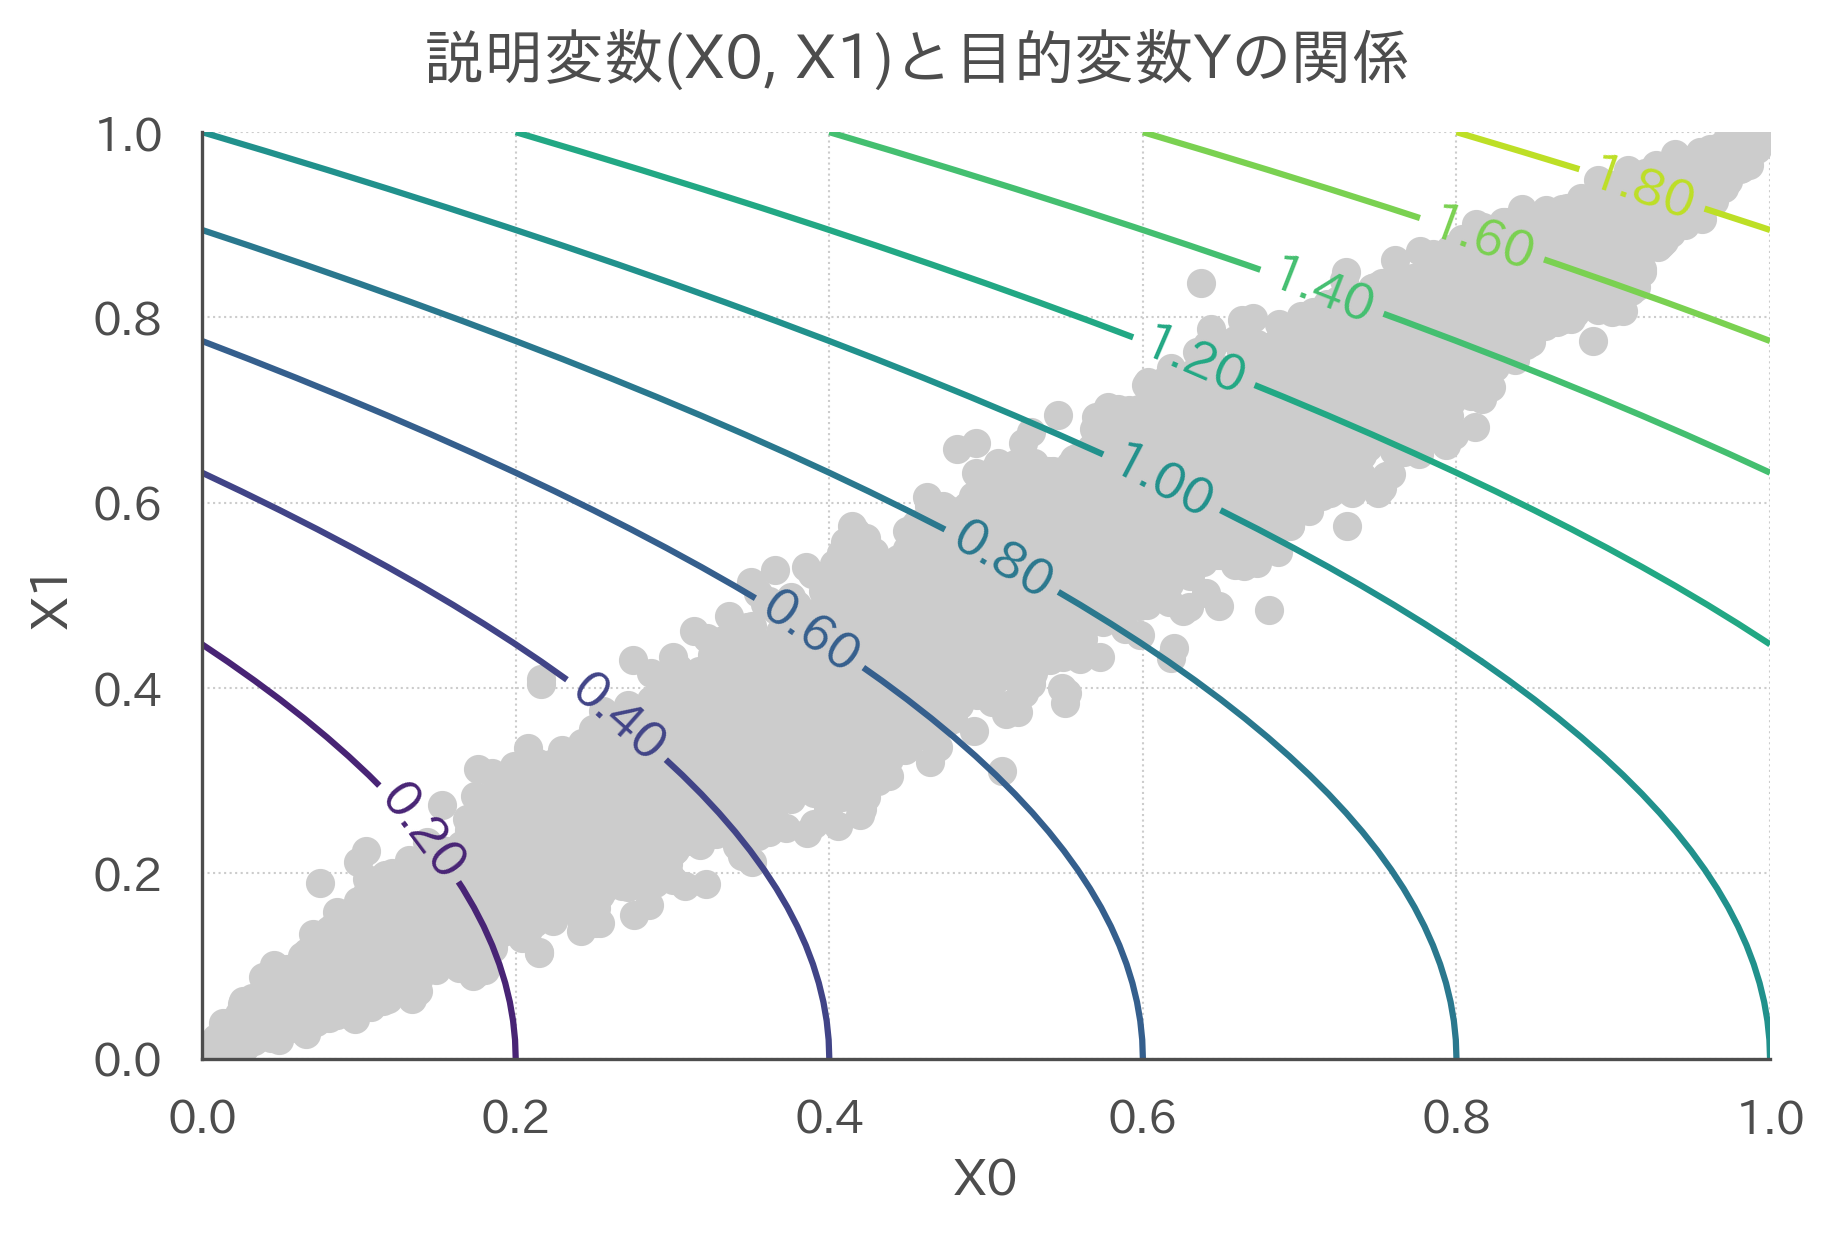

In [25]:
def draw_contour(
    X: np.ndarray,
    f1: Callable[[np.ndarray], np.ndarray], # 等高線引くための関数
    f2: Callable[[np.ndarray], np.ndarray] | None = None, # 2つまで指定可能
    xlabel: str | None = None,
    ylabel: str | None = None,
    title: str | None = None,
    cmaps: list[str] = ["viridis"],
) -> None:
    """等高線プロット"""

    x = np.linspace(0, 1, num=50)

    fig, ax = plt.subplots()

    ax.scatter(X[:, 0], X[:, 1], c=".8")

    z = f1(cartesian([x, x])).reshape(50, 50, order="F")
    CS = ax.contour(x, x, z, levels=10, cmap=cmaps[0])
    ax.clabel(CS, fmt="%1.2f")

    if f2 is not None:
        z = f2(cartesian([x, x])).reshape(50, 50, order="F")
        CS = ax.contour(x, x, z, levels=10, cmap=cmaps[1])
        ax.clabel(CS, fmt="%1.2f")

    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)

    fig.show()


draw_contour(X=X, f1=f, xlabel="X0", ylabel="X1", title="説明変数(X0, X1)と目的変数Yの関係")

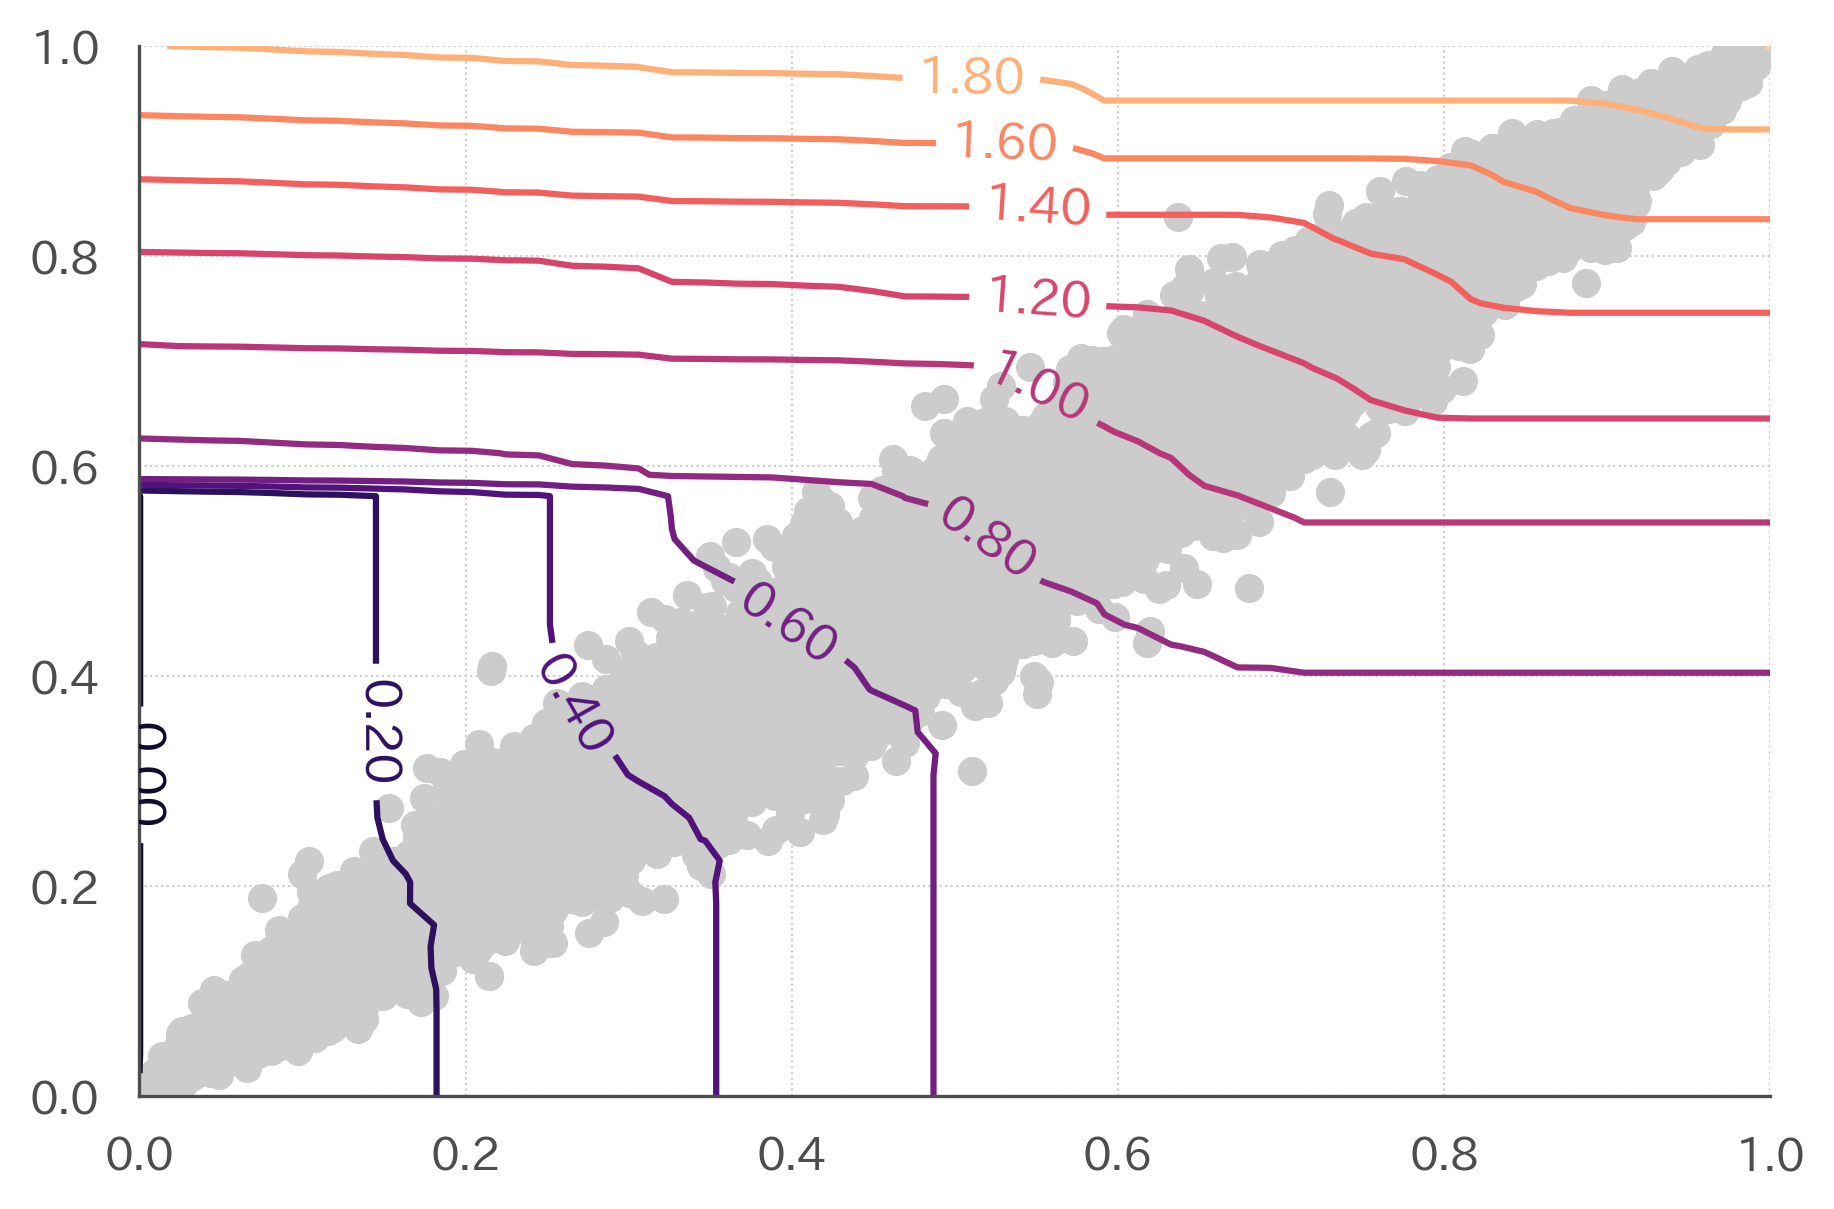

In [5]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X, y)

draw_contour(X=X, f1=rf.predict, cmaps=['magma'])

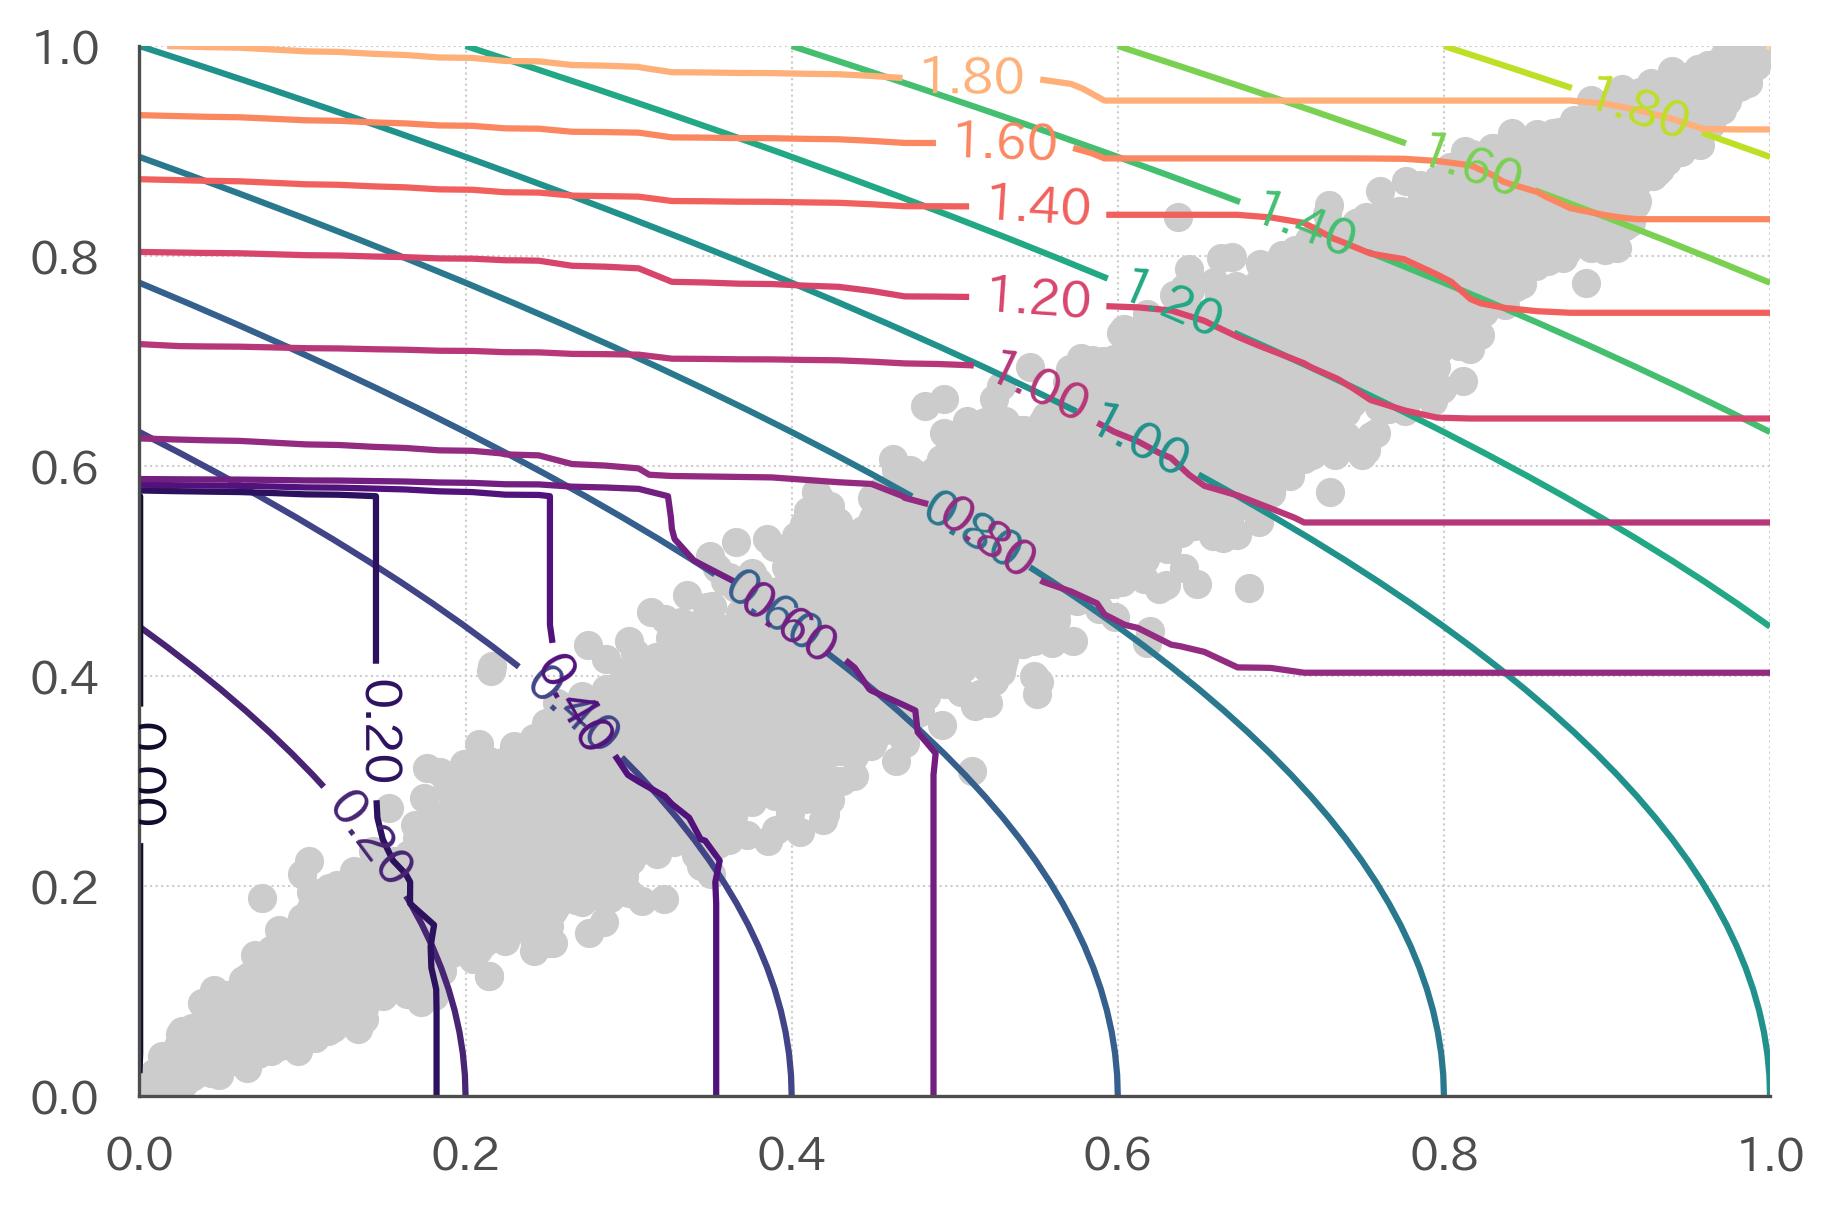

In [6]:
draw_contour(X=X, f1=f, f2=rf.predict, cmaps=['viridis', 'magma'])

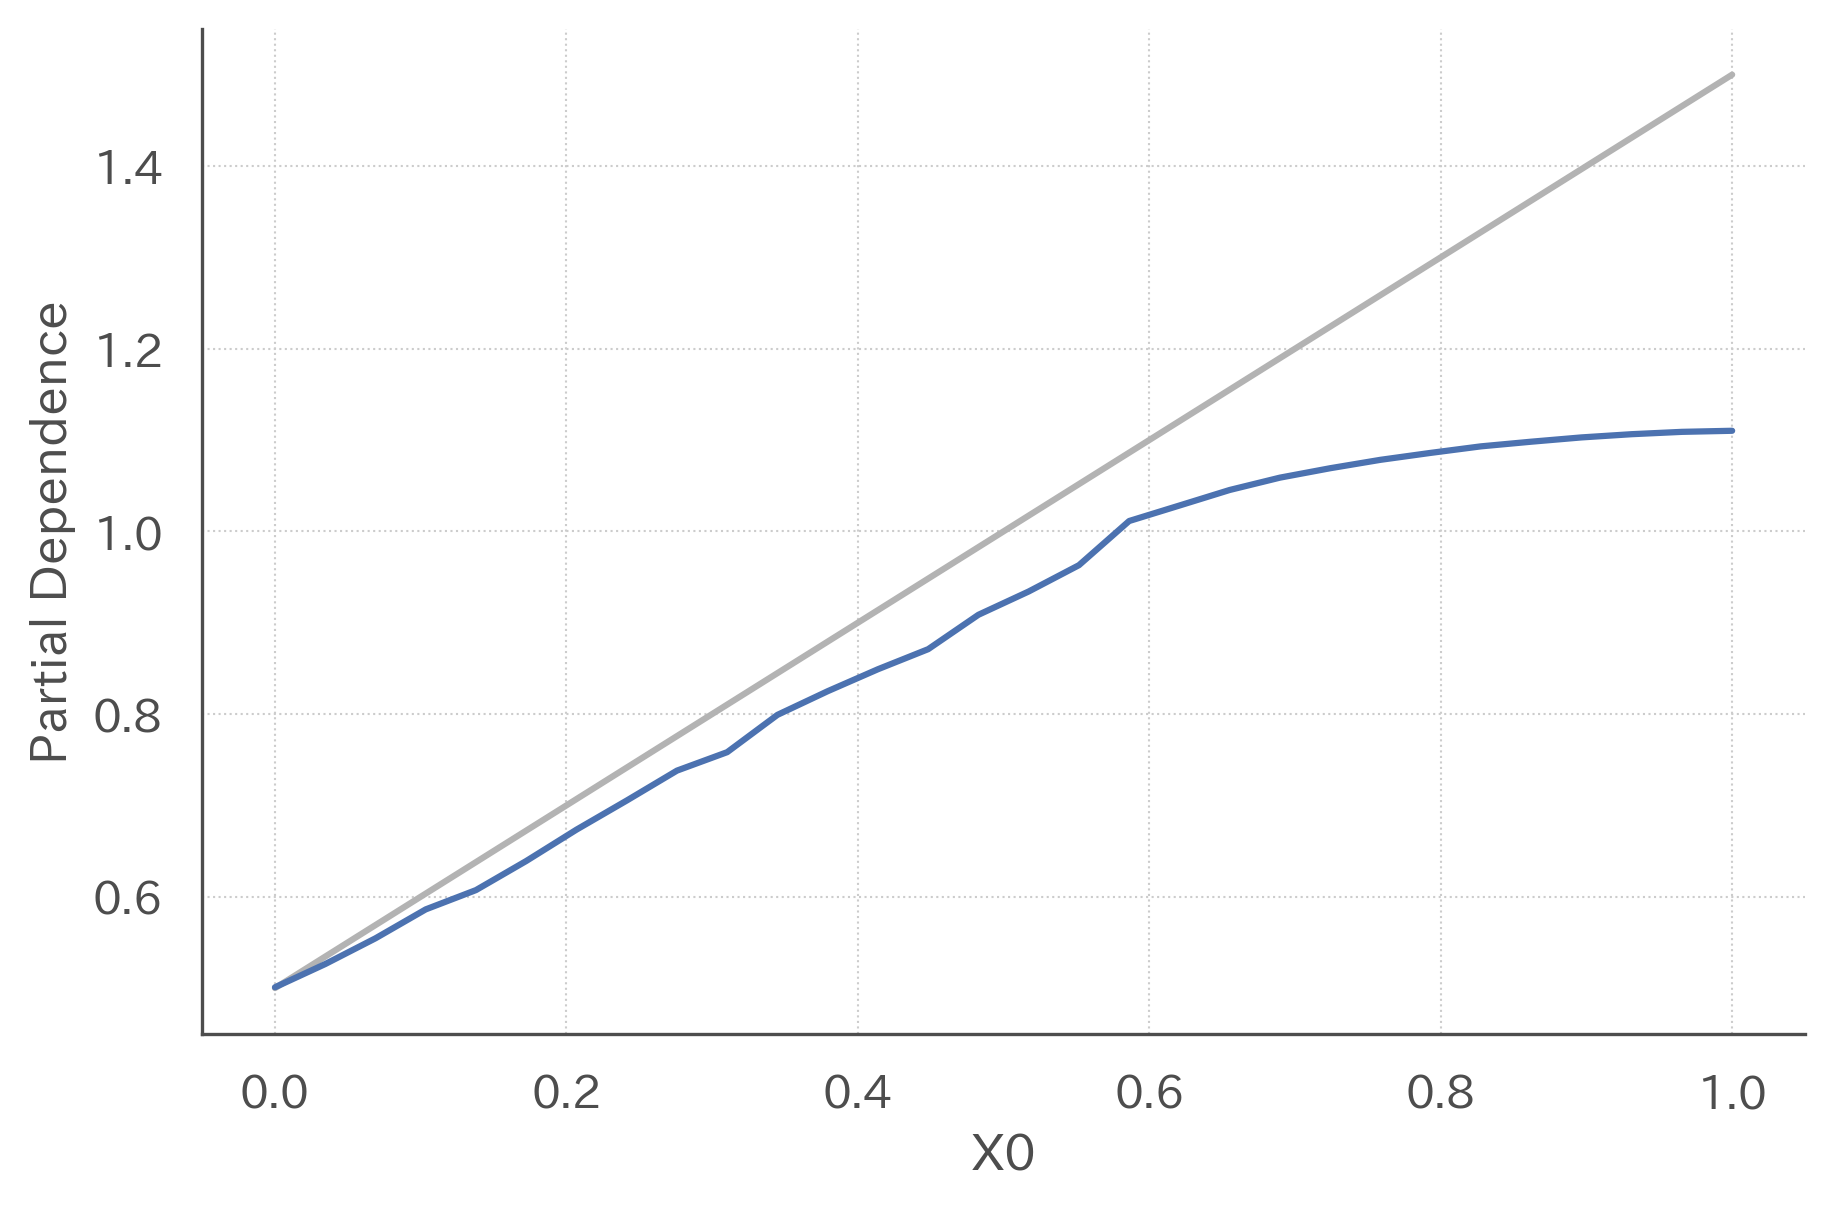

In [7]:


pd = PartialDependence(estimator=rf, X=X)
pd.partial_dependence(j=0)
pd.plot(f=lambda x: x + 0.5, ylabel="Partial Dependence", title=None)

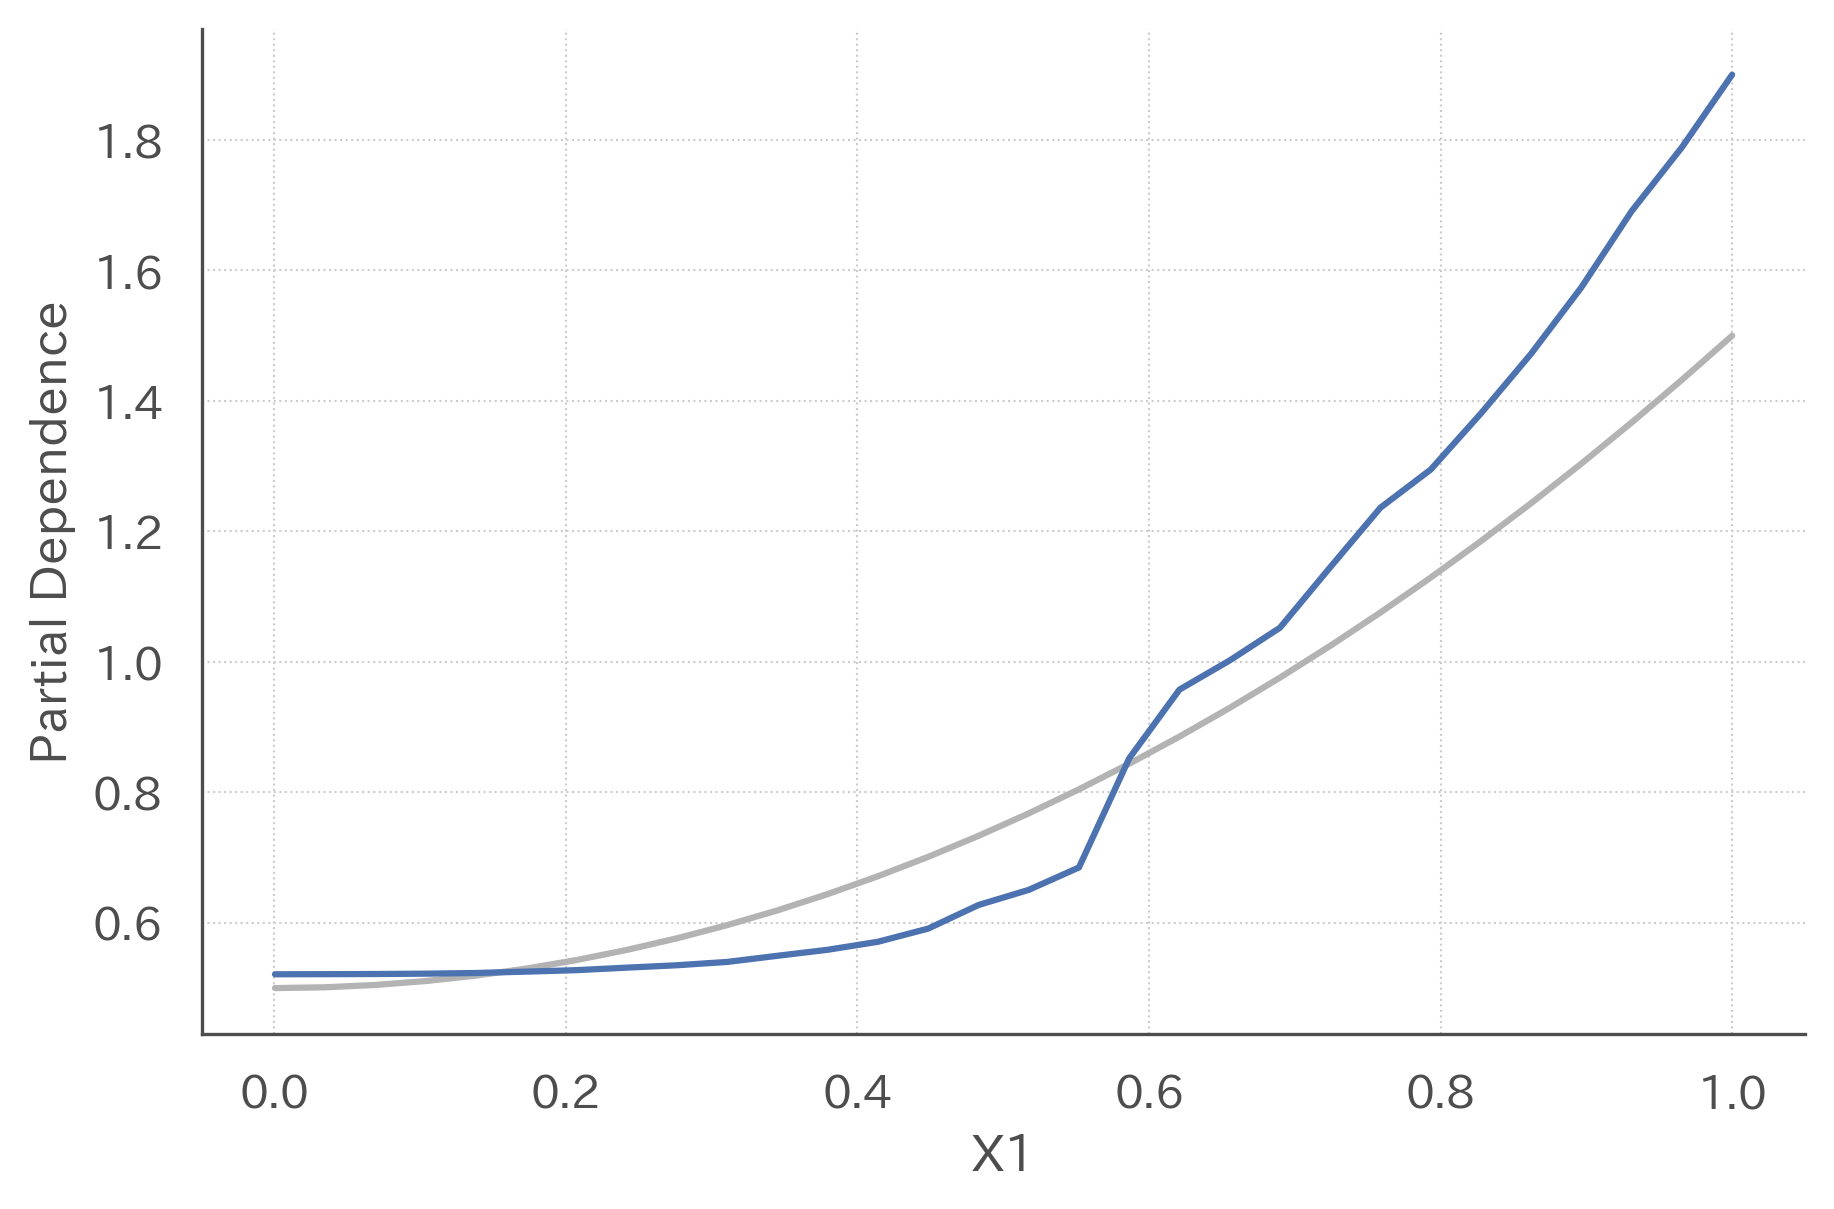

In [8]:
pd.partial_dependence(j=1)
pd.plot(f=lambda x: x ** 2 + 0.5, ylabel="Partial Dependence", title=None)

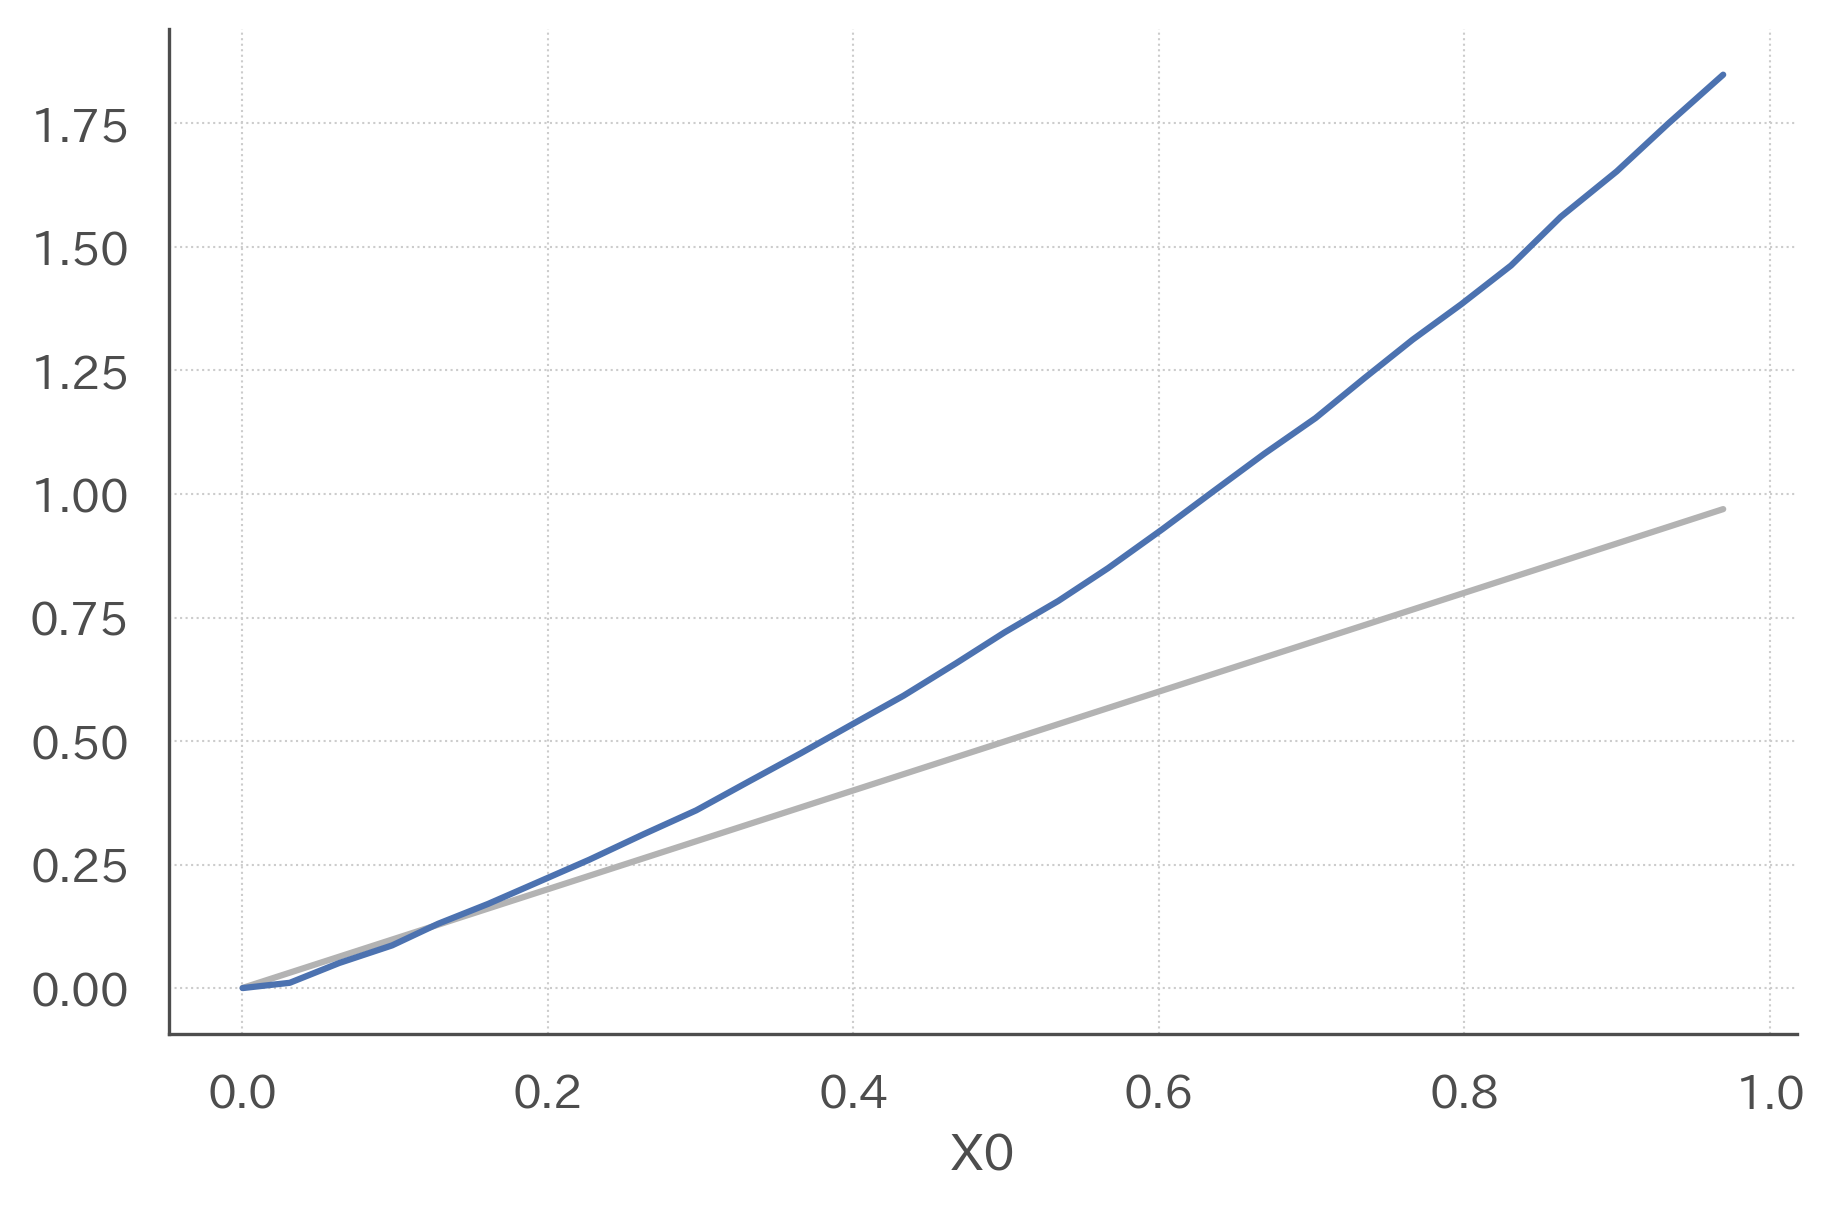

In [17]:
from mli import Marginal

m = Marginal(estimator=rf, X=X)
m.marginal(j=0)
m.plot(f=lambda x: x)

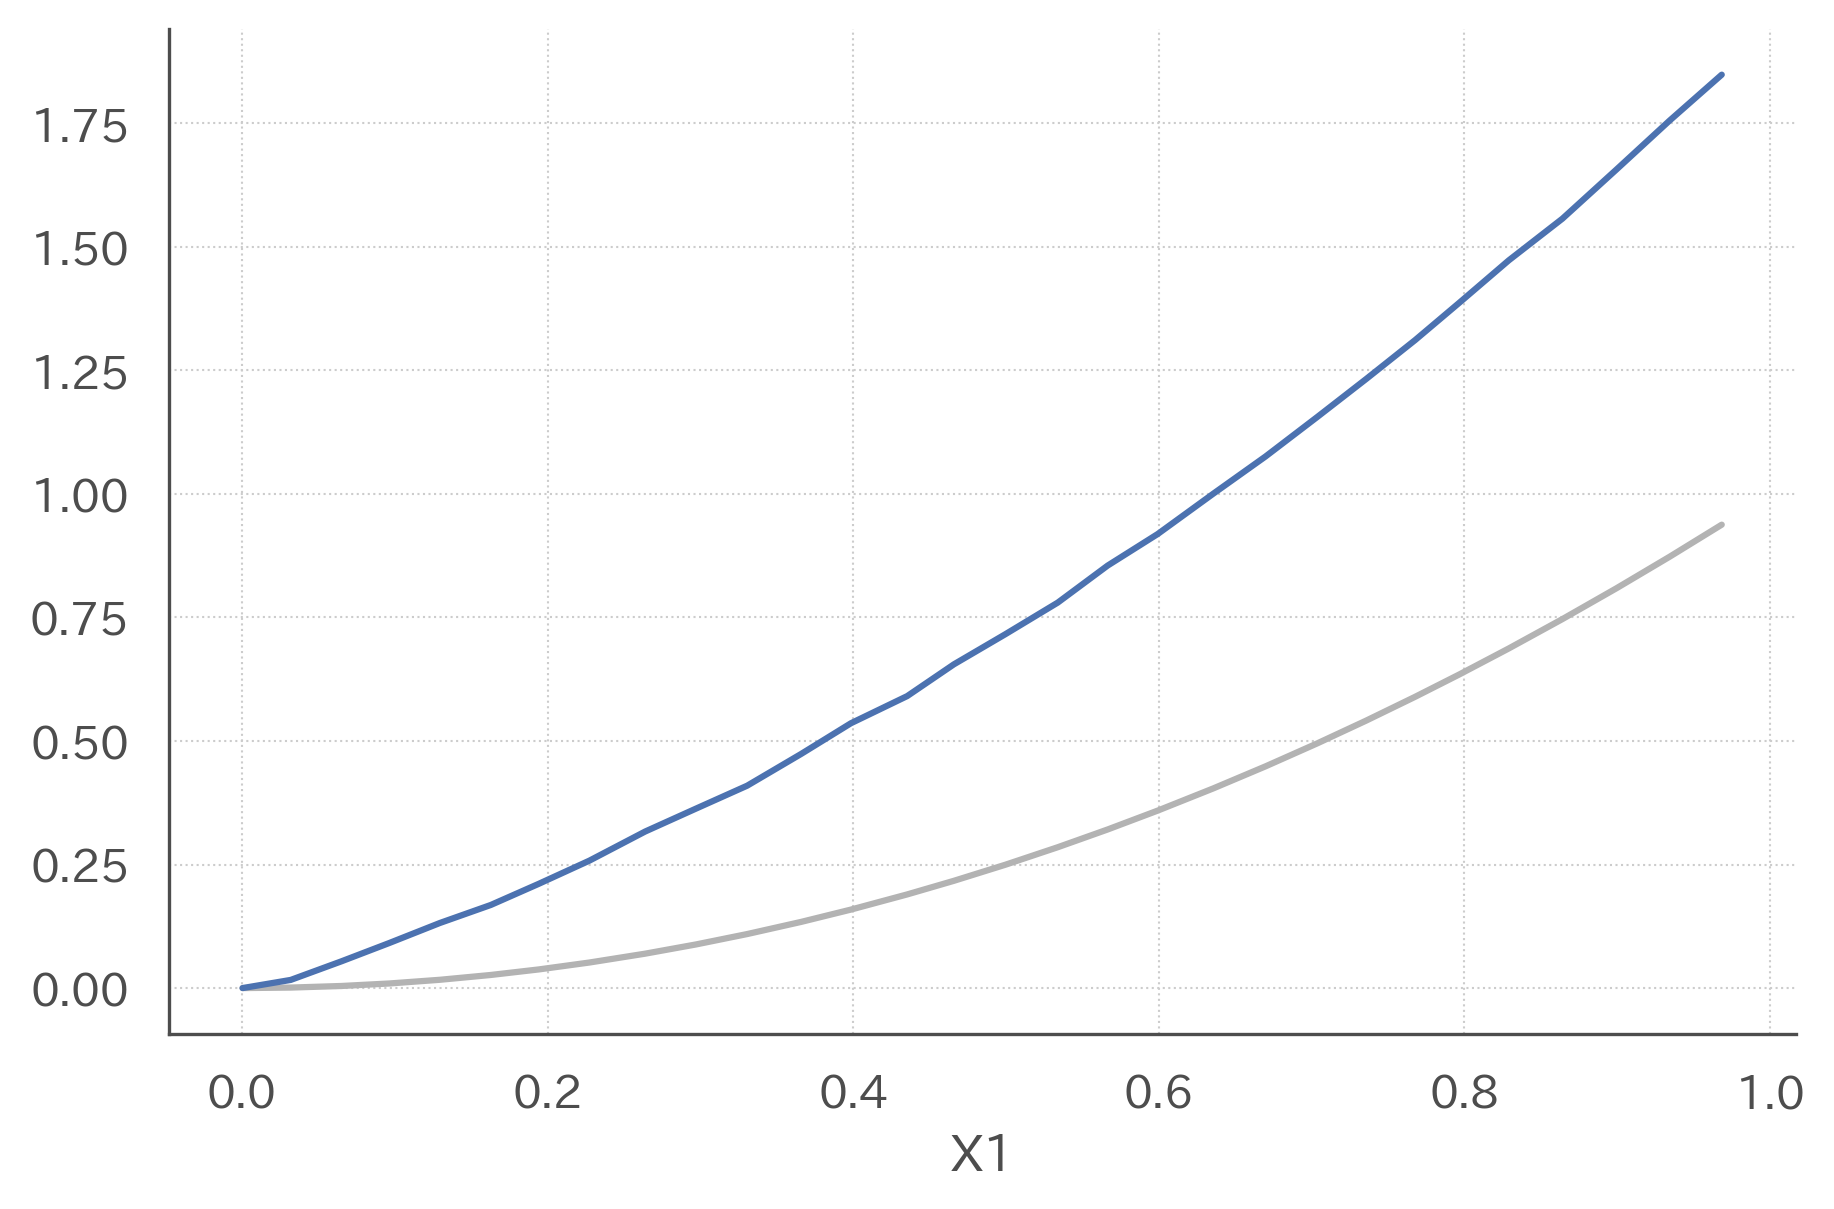

In [11]:
m.marginal(j=1)
m.plot(f=lambda x: x ** 2)

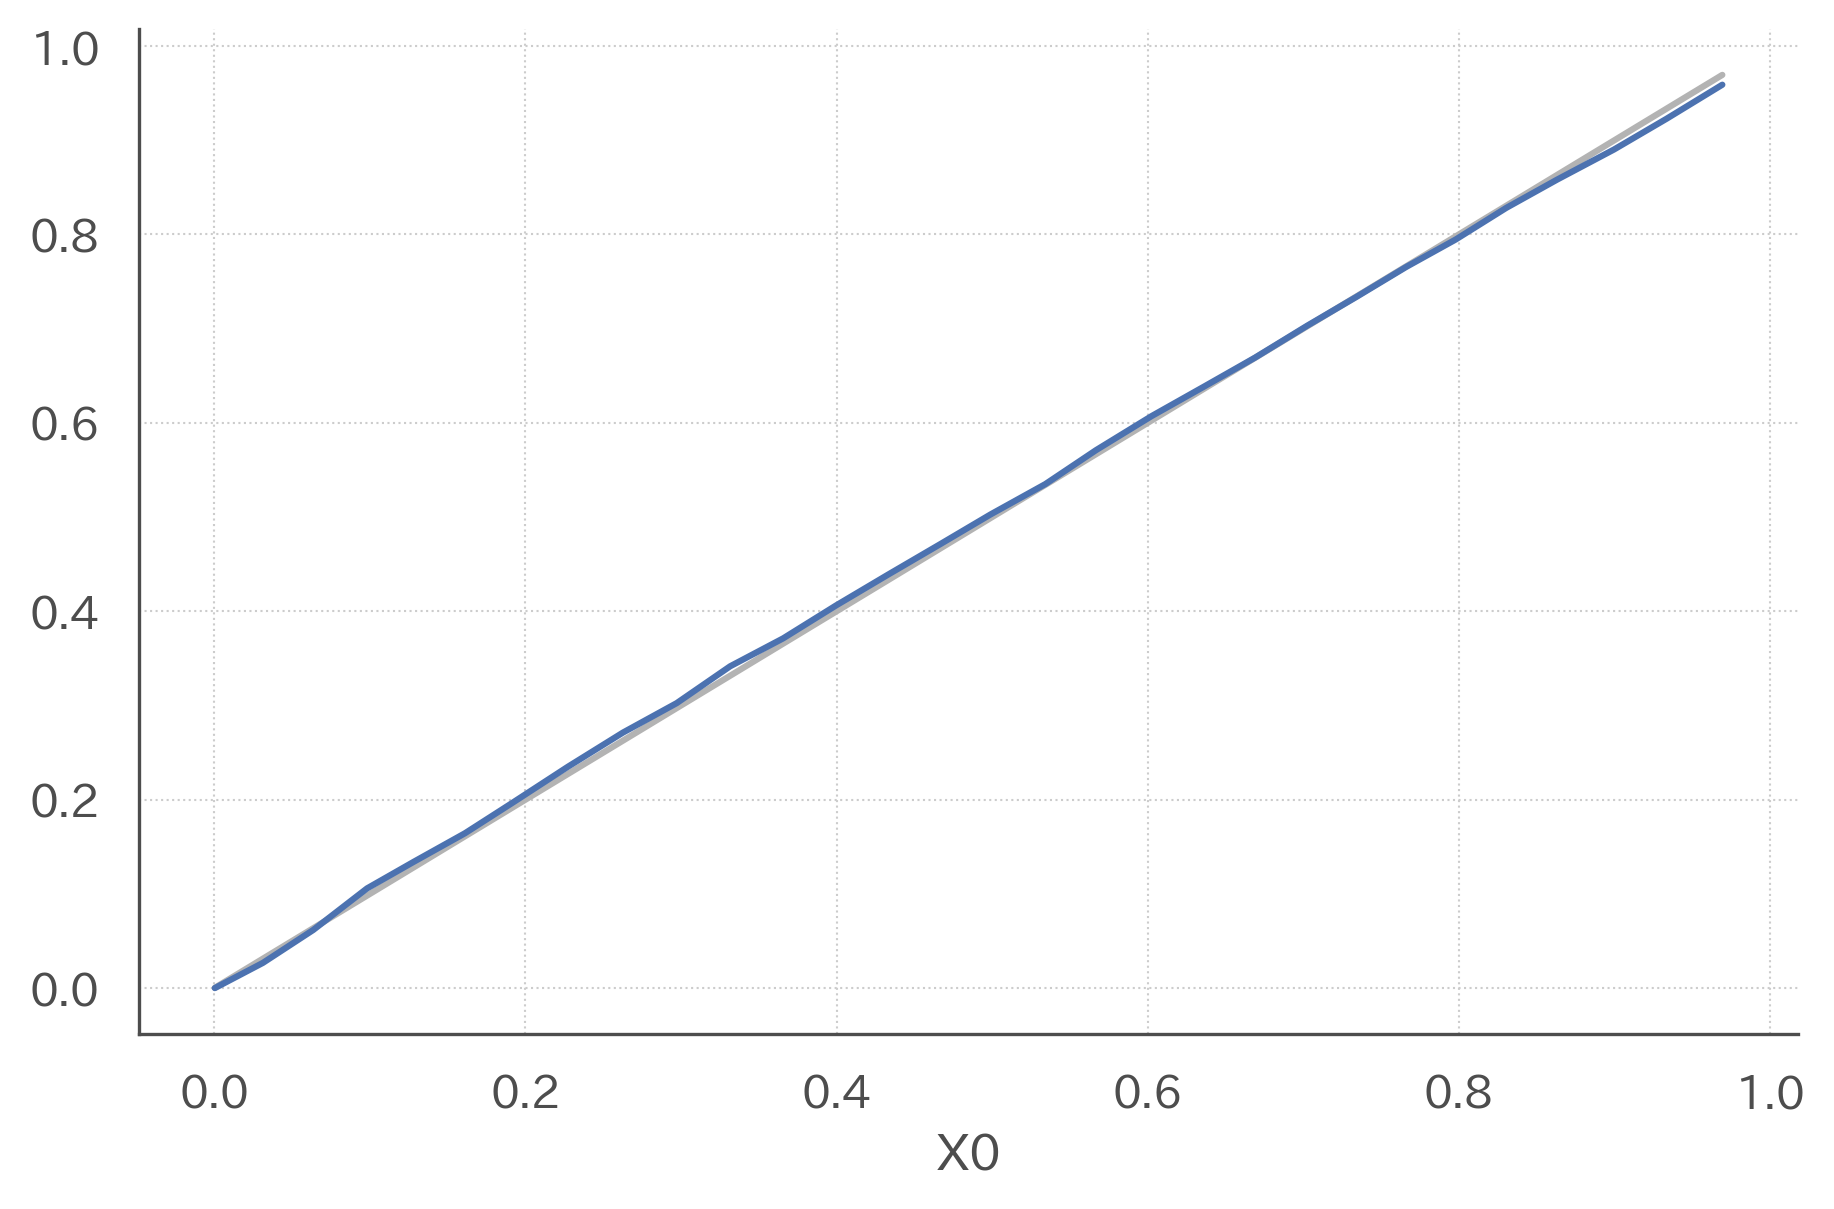

In [16]:
from mli import AccumulatedLocalEffects

ale = AccumulatedLocalEffects(estimator=rf, X=X)
ale.accumulated_local_effects(j=0)
ale.plot(f=lambda x: x)

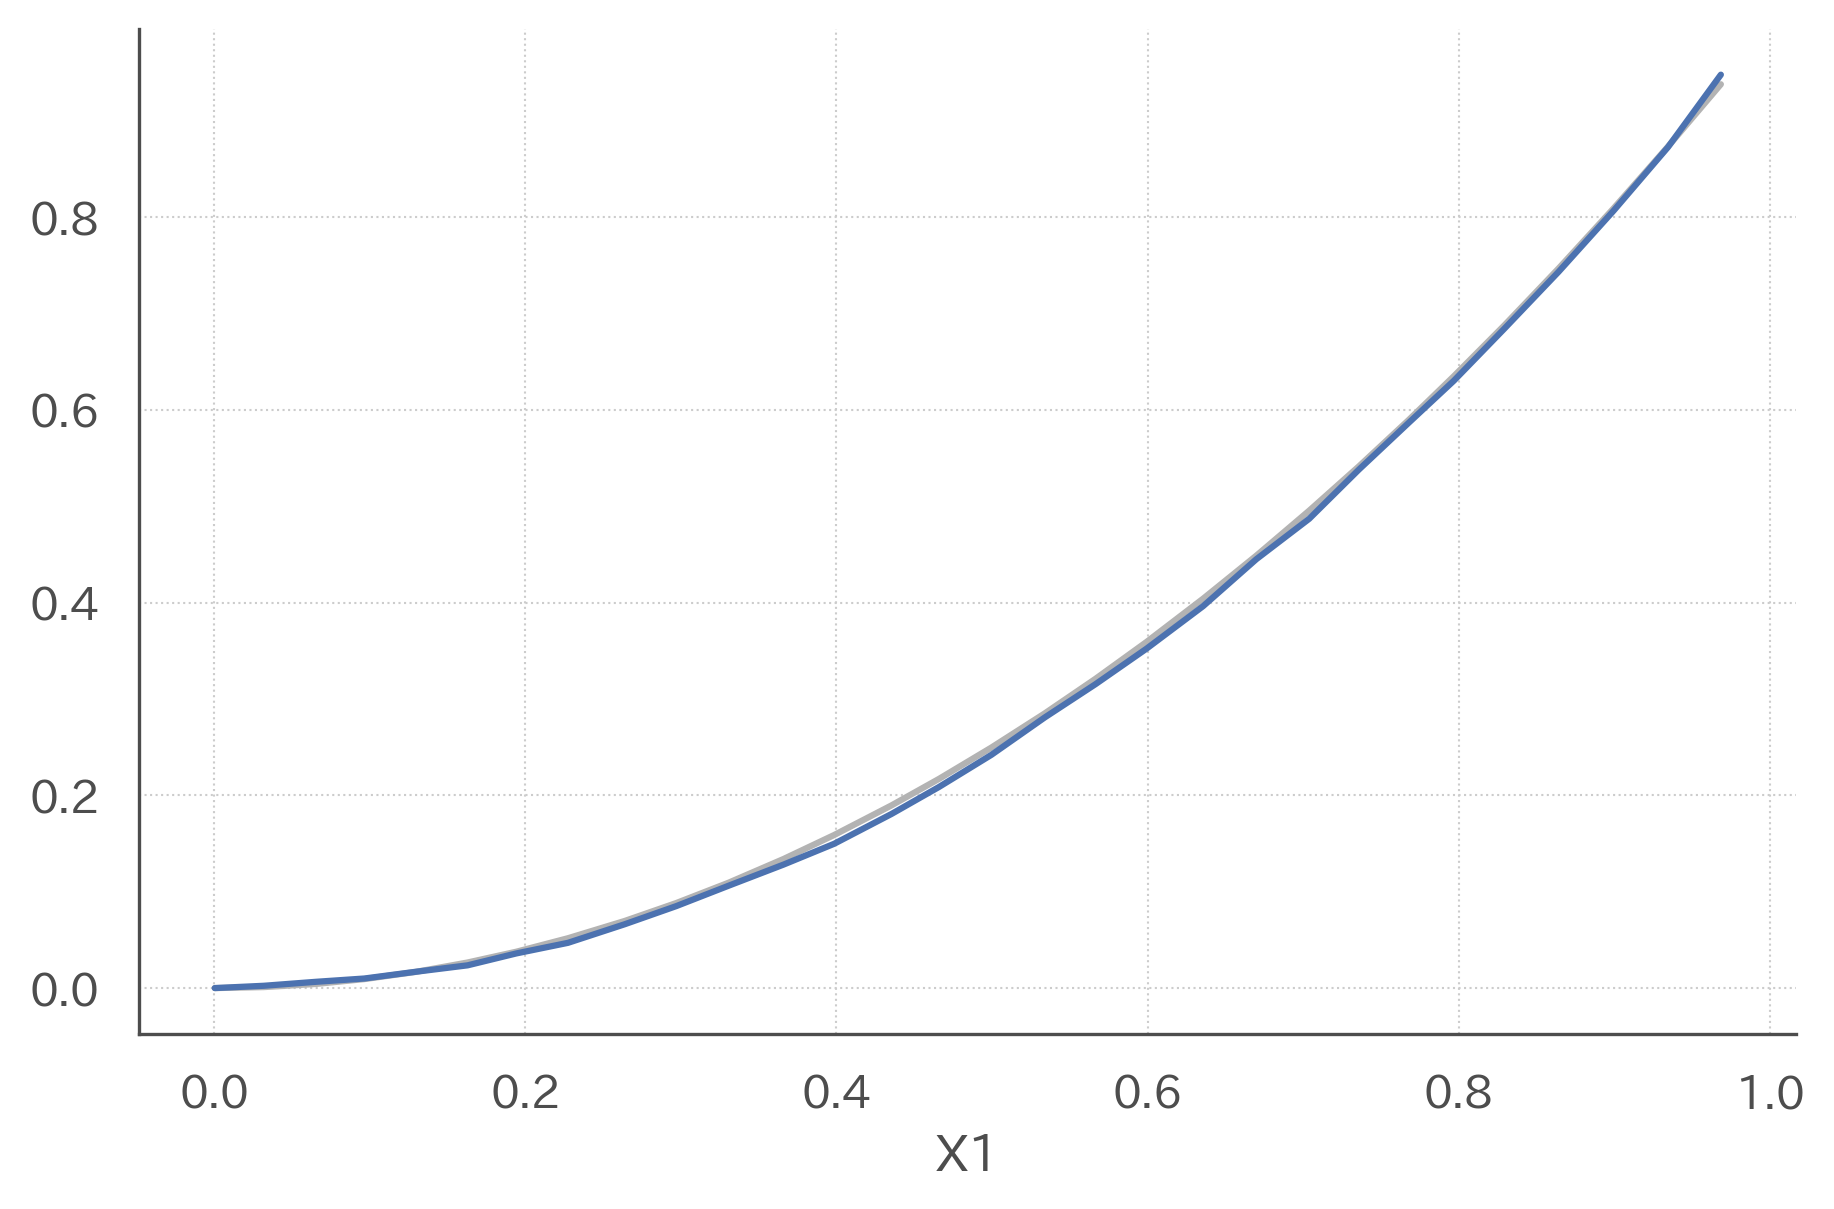

In [14]:
ale.accumulated_local_effects(j=1)
ale.plot(f=lambda x: x ** 2)